# Loading the Dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#importing seaborn for statistical plots
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import feather

events_df = pd.read_csv("Events_data.csv")
events_df.info()

/Users/rm185431/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   time                 1000000 non-null  object 
 1   dcs_severity         1000000 non-null  int64  
 2   dcs_eventid          1000000 non-null  object 
 3   dcs_data             586945 non-null   object 
 4   dcs_count            193847 non-null   float64
 5   dcs_description      999998 non-null   object 
 6   dcs_hostname         1000000 non-null  object 
 7   dcs_storeidentifier  997327 non-null   object 
 8   dcs_managed          1000000 non-null  bool   
 9   dcs_assetName        413161 non-null   object 
 10  dcs_category         871230 non-null   object 
 11  dcs_device           1000000 non-null  object 
 12  dcs_customer         1000000 non-null  object 
 13  asset_id             1000000 non-null  object 
 14  event_date           1000000 non-null  object 
dtyp

In [2]:
events_df.head()

,time,dcs_severity,dcs_eventid,dcs_data,dcs_count,dcs_description,dcs_hostname,dcs_storeidentifier,dcs_managed,dcs_assetName,dcs_category,dcs_device,dcs_customer,asset_id,event_date
0,2020-07-14T20:30:02.901-04:00,2,DISCONNECTED,eventData.assetName:WMT_00_23_24_39_3B_34:even...,1.0,undefined,SC047S05546US,NaN,True,NaN,undefined,Connectivity,Walmart,WMT_00_23_24_39_3B_34,7/14/20
1,2020-07-15T16:50:42.247-04:00,2,DISCONNECTED,eventData.assetName:WMT_30_0E_D5_37_C2_94:even...,1.0,undefined,SC044S05546US,NaN,True,NaN,undefined,Connectivity,Walmart,WMT_30_0E_D5_37_C2_94,7/15/20
2,2020-07-16T10:20:48.223-04:00,2,DISCONNECTED,eventData.assetName:WMT_30_0E_D5_37_C2_94:even...,1.0,undefined,SC044S05546US,NaN,True,NaN,undefined,Connectivity,Walmart,WMT_30_0E_D5_37_C2_94,7/16/20
3,2020-07-14T02:20:03.091-04:00,2,DISCONNECTED,eventData.assetName:WMT_00_23_24_39_3B_34:even...,1.0,undefined,SC047S05546US,NaN,True,NaN,undefined,Connectivity,Walmart,WMT_00_23_24_39_3B_34,7/14/20
4,2020-10-15T20:05:10.128-04:00,2,DISCONNECTED,eventData.assetName:WMT_00_50_56_9D_E7_4D:even...,1.0,This is SNMP offline ping event,phont30111us,WMT Datacenter,True,NaN,PropertySubscription,Connectivity,Walmart,WMT_00_50_56_9D_E7_4D,10/15/20


In [3]:
events_df.shape

(1000000, 15)

Statistical Relation between columns

Drop irrelevant columns

event_id, severity and event_description are related. 
for severity=10, event_id and event_description values are same.
for severity=4,2 and 1, event_id and event_description are co-related. exampled : DCS097-3221296054 -> SM out of service base
(i.e) with event_id and severity we can derive the vent_description.

dcs_device and event_id are correlated - dropping dcs_device.

In [4]:
candidates = ["time", "dcs_customer", "dcs_data", "dcs_managed", "dcs_assetName", "dcs_count", "dcs_description", "dcs_device", "asset_id"]
events_df.drop(columns=[col for col in candidates if col in events_df.columns], inplace=True)

Get the assetName from the eventData

In [5]:
def extract_asset_name(eventData):
    if eventData is np.nan:
        return '0' 
    else:
        return eventData.split(":")[1]

In [6]:
#events_df['new_assetName'] = events_df.apply(lambda row: extract_asset_name(row['dcs_data']) if row['dcs_assetName'] is np.nan else row['dcs_assetName'], axis=1)

In [7]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dcs_severity         1000000 non-null  int64 
 1   dcs_eventid          1000000 non-null  object
 2   dcs_hostname         1000000 non-null  object
 3   dcs_storeidentifier  997327 non-null   object
 4   dcs_category         871230 non-null   object
 5   event_date           1000000 non-null  object
dtypes: int64(1), object(5)
memory usage: 45.8+ MB


In [8]:
events_df['dcs_storeidentifier'] = events_df.apply(lambda row: row['dcs_hostname'][-6:-2] if row['dcs_hostname'] else '0000', axis=1)

Encode dcs_storeidentifier

In [9]:
events_df.nunique()

dcs_severity               4
dcs_eventid               92
dcs_hostname           68525
dcs_storeidentifier     4558
dcs_category              10
event_date               120
dtype: int64

Find and Replace

In [10]:
events_df = events_df.fillna({"dcs_category": "undefined", "dcs_storeidentifier":"0"})

In [11]:
events_df["dcs_storeidentifier"] = events_df["dcs_storeidentifier"].astype(int)

In [12]:
events_df.drop(columns=["dcs_hostname"], inplace=True)

In [13]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dcs_severity         1000000 non-null  int64 
 1   dcs_eventid          1000000 non-null  object
 2   dcs_storeidentifier  1000000 non-null  int64 
 3   dcs_category         1000000 non-null  object
 4   event_date           1000000 non-null  object
dtypes: int64(2), object(3)
memory usage: 38.1+ MB


In [14]:
events_df["dcs_category"] = events_df["dcs_category"].astype('category')

In [15]:
events_df = pd.get_dummies(events_df, columns=["dcs_category"])

In [16]:
events_df['event_health'] = events_df.apply(lambda row: 1 if (row['dcs_severity']==0 or row['dcs_severity']==10) else 0 , axis=1)

In [17]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                             Non-Null Count    Dtype 
---  ------                             --------------    ----- 
 0   dcs_severity                       1000000 non-null  int64 
 1   dcs_eventid                        1000000 non-null  object
 2   dcs_storeidentifier                1000000 non-null  int64 
 3   event_date                         1000000 non-null  object
 4   dcs_category_BNR Empty             1000000 non-null  uint8 
 5   dcs_category_BNR Error             1000000 non-null  uint8 
 6   dcs_category_BNR Jammed            1000000 non-null  uint8 
 7   dcs_category_BNR Open              1000000 non-null  uint8 
 8   dcs_category_Event Log             1000000 non-null  uint8 
 9   dcs_category_GenSW                 1000000 non-null  uint8 
 10  dcs_category_PropertySubscription  1000000 non-null  uint8 
 11  dcs_category_SNMP Ping Fail Event  100

In [18]:
def convert_eventId_num(eventId):
    if eventId == "DCS-DGRD-Cash":
        return "001"
    elif "DCS" in eventId:
        return eventId.replace("DCS","").replace("-","")
    elif eventId == "DISCONNECTED":
        return "002"
    elif eventId == "fnch-GenSW":
        return "003"
    elif eventId == "fnch-BNRError":
        return "004"
    elif eventId == "fnch-BNRJammed":
        return "005"
    elif eventId == "fnch-BNROpen":
        return "006"
    elif eventId == "fnch-BNREmpty":
        return "007"
    else:
        return "008"

In [19]:
def convert_num_eventId(eventId):
    return "DCS" + eventId[0:3] + "-" + eventId[3:]

eventId=DISCONNECTED, n=156470 (15.647%)
eventId=DCS097-3221361619, n=818 (0.082%)
eventId=DCS003-1610617750, n=584 (0.058%)
eventId=DCS063-2148478505, n=111 (0.011%)
eventId=DCS097-3221296054, n=295 (0.030%)
eventId=DCS028-3758434072, n=53 (0.005%)
eventId=DCS035-1073932996, n=13 (0.001%)
eventId=DCS063-1074736670, n=176 (0.018%)
eventId=DCS063-1074736671, n=2912 (0.291%)
eventId=DCS028-3759154994, n=191 (0.019%)
eventId=DCS063-3222220325, n=594 (0.059%)
eventId=DCS028-3759155007, n=69 (0.007%)
eventId=DCS063-3222220326, n=1234 (0.123%)
eventId=DCS054-3758430097, n=67 (0.007%)
eventId=DCS004-12801, n=58 (0.006%)
eventId=DCS029-2685413257, n=28 (0.003%)
eventId=DCS004-8728, n=34 (0.003%)
eventId=DCS005-1610622736, n=117 (0.012%)
eventId=DCS035-2148526992, n=15 (0.002%)
eventId=DCS029-3759155060, n=196 (0.020%)
eventId=DCS028-2685413195, n=3 (0.000%)
eventId=DCS097-3221689409, n=2367 (0.237%)
eventId=DCS028-3759154988, n=270 (0.027%)
eventId=DCS004-8731, n=8 (0.001%)
eventId=DCS028-3759

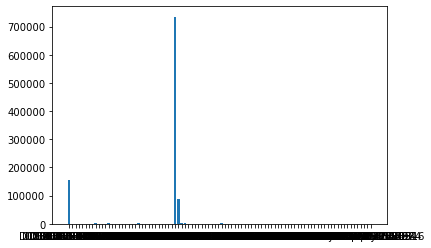

In [20]:
# plot the distribution of eventid
eventId_dict = dict()
eventId = events_df['dcs_eventid']
from collections import Counter
from matplotlib import pyplot
counter = Counter(eventId)
for k,v in counter.items():
	per = v / len(eventId) * 100
	print('eventId=%s, n=%d (%.3f%%)' % (k, v, per))
	if v > 50:
		eventId_dict[k]=convert_eventId_num(k) 
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [21]:
cleanup_eventId = {
     "dcs_eventid" : eventId_dict
                }
events_df = events_df.replace(cleanup_eventId)

In [22]:
events_df["dcs_eventid"] = events_df["dcs_eventid"].astype('category')

In [23]:
events_df.head()

,dcs_severity,dcs_eventid,dcs_storeidentifier,event_date,dcs_category_BNR Empty,dcs_category_BNR Error,dcs_category_BNR Jammed,dcs_category_BNR Open,dcs_category_Event Log,dcs_category_GenSW,dcs_category_PropertySubscription,dcs_category_SNMP Ping Fail Event,dcs_category_Usage Alarm,dcs_category_undefined,event_health
0,2,002,5546,7/14/20,0,0,0,0,0,0,0,0,0,1,0
1,2,002,5546,7/15/20,0,0,0,0,0,0,0,0,0,1,0
2,2,002,5546,7/16/20,0,0,0,0,0,0,0,0,0,1,0
3,2,002,5546,7/14/20,0,0,0,0,0,0,0,0,0,1,0
4,2,002,111,10/15/20,0,0,0,0,0,0,1,0,0,0,0


In [27]:
def convert_date_yymmdd(event_date):
    word_list = event_date.split("/")
    if len(word_list)==3:
        return word_list[-1]+word_list[-3].zfill(2)+word_list[-2].zfill(2)
    else:
        return "000000"

In [28]:
def convert_yymmdd_date(event_date):
   return event_date[-4:-2].lstrip("0") + "/"+ event_date[-2:].lstrip("0") + "/" + event_date[0:2]

In [29]:
events_df['event_date'] = events_df['event_date'].apply(lambda row: convert_date_yymmdd(row))

In [30]:
events_df.head(10)

,dcs_severity,dcs_eventid,dcs_storeidentifier,event_date,dcs_category_BNR Empty,dcs_category_BNR Error,dcs_category_BNR Jammed,dcs_category_BNR Open,dcs_category_Event Log,dcs_category_GenSW,dcs_category_PropertySubscription,dcs_category_SNMP Ping Fail Event,dcs_category_Usage Alarm,dcs_category_undefined,event_health
0,2,002,5546,200714,0,0,0,0,0,0,0,0,0,1,0
1,2,002,5546,200715,0,0,0,0,0,0,0,0,0,1,0
2,2,002,5546,200716,0,0,0,0,0,0,0,0,0,1,0
3,2,002,5546,200714,0,0,0,0,0,0,0,0,0,1,0
4,2,002,111,201015,0,0,0,0,0,0,1,0,0,0,0
5,2,002,112,201016,0,0,0,0,0,0,1,0,0,0,0
6,2,002,111,201014,0,0,0,0,0,0,1,0,0,0,0
7,2,002,110,201016,0,0,0,0,0,0,1,0,0,0,0
8,2,002,110,201015,0,0,0,0,0,0,1,0,0,0,0
9,2,002,112,201018,0,0,0,0,0,0,1,0,0,0,0


In [39]:
events_df.to_feather('DCS_Events_preprocessed.feather')

requirement.txt:
pip install pyarrow